In [ ]:
!nvidia-smi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D,concatenate, Input, LeakyReLU
from keras.layers import BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from functools import partial
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
import tensorflow as tf

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import shutil
import numpy as np

In [ ]:
!mkdir esrgan_data

In [ ]:
!unzip drive/MyDrive/ESRGAN_data2.zip -d esrgan_data

In [ ]:
!mv esrgan_data/ESRGAN-Datasets ESRGAN-Datasets 

In [ ]:
!ls ESRGAN-Datasets

HR  LR


# Generator Model

In [ ]:
def RDB(nf, gc, x, beta):
  conv2d = partial(Conv2D, kernel_size=3, padding='same')
  lrelu = partial(LeakyReLU, alpha=0.2)

  x1 = conv2d(filters=gc, activation=lrelu())(x)
  x2 = conv2d(filters=gc, activation=lrelu())(concatenate([x,x1]))
  x3 = conv2d(filters=gc, activation=lrelu())(concatenate([x,x1,x2]))
  x4 = conv2d(filters=gc, activation=lrelu())(concatenate([x,x1,x2,x3]))
  x5 = conv2d(filters=nf)(concatenate([x,x1,x2,x3,x4]))

  return x + x5 * beta


In [ ]:
def RRDB(nf, gc, x, beta):
  RDB1 = RDB(nf, gc, x, beta)
  RDB2 = RDB(nf, gc, RDB1, beta)
  RDB3 = RDB(nf, gc, RDB2, beta)

  return x + RDB3 * beta

In [ ]:
def Generator_model(size, num_res_block=16, nf=64, gc=32, beta=0.2):

  low_res = Input(shape=(size, size, 3))
  conv1 = Conv2D(filters=nf, kernel_size=3, padding='same')(low_res)

  x = conv1
  for _ in range(num_res_block):
    x = RRDB(nf, gc, x, beta)
  x = Conv2D(filters=nf, kernel_size=3, padding='same')(x)
  x = x + conv1

  #-----UpSampling-----

  upsampled1 = Resizing(size*2, size*2,interpolation='bicubic')(x)
  x = Conv2D(filters=nf,kernel_size=3,padding='same',activation=LeakyReLU(alpha=0.2))(upsampled1)
  upsampled2 = Resizing(size*4, size*4,interpolation='bicubic')(x)
  x = Conv2D(filters=nf,kernel_size=3,padding='same',activation=LeakyReLU(alpha=0.2))(upsampled2)
  finalConv = Conv2D(filters=3,kernel_size=3,padding='same',activation='sigmoid')(x)

  model = Model(inputs=low_res, outputs=finalConv)

  return model



# Generator Loss

In [ ]:
from keras.applications.vgg19 import preprocess_input, VGG19
from keras.models import  Model
from keras.losses import MeanSquaredError, BinaryCrossentropy
from keras.activations import sigmoid
import tensorflow as tf

In [ ]:
def percepLoss(feaLayer=54):
  vggModel = VGG19(include_top=False, weights='imagenet', input_shape=(None,None,3))

  outLayer_num = 20
  
  vggModel.layers[outLayer_num].activation = None   # before activation

  fea_extractor = Model(inputs=vggModel.input, outputs=vggModel.layers[outLayer_num].output)
  MSE = MeanSquaredError()

  def percep_loss(HR, SR):
    SR = preprocess_input(SR*255.) / 12.75
    HR = preprocess_input(HR*255.) / 12.75

    SR_fea = fea_extractor(SR)
    HR_fea = fea_extractor(HR)

    return MSE(HR_fea, SR_fea)
    
  return percep_loss


In [ ]:
def RaG_loss(HR, SR): 
  """
  HR and SR are discriminator outputs"""
  RaD = lambda x1,x2: sigmoid(x1-tf.reduce_mean(x2))
  cross_entropy = BinaryCrossentropy(from_logits=False)
  
  loss = cross_entropy( tf.zeros_like(SR), RaD(HR,SR) ) + cross_entropy( tf.ones_like(SR), RaD(SR,HR) )
  
  return loss*0.5

# Discriminator Model

In [ ]:
def Discriminator_Model(size):
  lrelu = LeakyReLU(alpha=0.2)

  def Block(x, n, s):
    Conv = Conv2D(filters=n, kernel_size=3, strides=(s,s))(x)
    BN = BatchNormalization()(Conv)
    LR = lrelu(BN)
    return LR 
  
  input_layer = Input((size,size,3))
  x = Conv2D(64,3, activation=lrelu)(input_layer)

  block_hparams = [[64,2],[128,1],[128,2],
                   [256,1],[256,2],[512,1],[512,2]]
  for hp in block_hparams:
    x = Block(x, *hp)
  x = Flatten()(x)
  x = Dense(1024, activation=lrelu)(x)
  output = Dense(1,activation='sigmoid')(x)

  model = Model(inputs=input_layer, outputs=output)

  return model

# Discriminator Loss

In [ ]:
def RaD_loss(HR, SR): 
  """
  HR and SR are discriminator outputs"""
  RaD = lambda x1,x2: sigmoid(x1-tf.reduce_mean(x2))
  cross_entropy = BinaryCrossentropy(from_logits=False)
  
  loss = cross_entropy( tf.ones_like(SR), RaD(HR,SR) ) +cross_entropy( tf.zeros_like(SR), RaD(SR,HR) )
  
  return loss*0.5

# Download and cropping

1) Downloading

In [ ]:
!ls

drive  sample_data


In [ ]:
#----Download Dataset----

# DIV2K, Flickr2K(textures), OST
# At first just train on DIV2K

#--download DIV2K dataset
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_mild.zip #4x
!unzip DIV2K_train_LR_mild.zip

!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!unzip DIV2K_train_HR.zip


2) Cropping

In [ ]:
x = os.listdir('DIV2K_train_HR')
y = os.listdir('DIV2K_train_LR_mild')
x.sort()
y.sort()
print(len(x), len(y))
print(x[:10])
print(y[:10])

800 800
['0001.png', '0002.png', '0003.png', '0004.png', '0005.png', '0006.png', '0007.png', '0008.png', '0009.png', '0010.png']
['0001x4m.png', '0002x4m.png', '0003x4m.png', '0004x4m.png', '0005x4m.png', '0006x4m.png', '0007x4m.png', '0008x4m.png', '0009x4m.png', '0010x4m.png']


In [ ]:
!mkdir 'DIV2K_train_HR(patches)'
!mkdir 'DIV2K_train_LR_mild(patches)'

In [ ]:
def crop(img, path, name, size, step):
  numStep_v = (img.shape[0]-size) // step
  numStep_h = (img.shape[1]-size) // step
  for v in range(numStep_v):
    for h in range(numStep_h):
      patchImg = img[v*step:v*step+size,
                     h*step:h*step+size]
      cv2.imwrite(path+'/%s(%d,%d).png'%(name,v,h),patchImg)

In [ ]:
size = 256
step = 200

for i in tqdm(range(800)):
  imgLR = cv2.imread('DIV2K_train_LR_mild/'+y[i])
  imgHR = cv2.imread('DIV2K_train_HR/'+x[i])
  crop(imgLR, 'DIV2K_train_LR_mild(patches)', y[i][:-4], size//4, step//4)
  crop(imgHR, 'DIV2K_train_HR(patches)', x[i][:-4], size, step)

  0%|          | 0/800 [00:00<?, ?it/s]

In [ ]:
print(len(os.listdir('DIV2K_train_HR(patches)')))
print(len(os.listdir('DIV2K_train_LR_mild(patches)')))

32312
32312


3) put them into multiple folders

In [ ]:
!mkdir HR
!mkdir LR

In [ ]:
#1- creat folders
for i in range(2,11):
  os.mkdir('HR/DIV2K_train_HR(patches)'+str(i))
  os.mkdir('LR/DIV2K_train_LR_mild(patches)'+str(i))

In [ ]:
!mv 'DIV2K_train_LR_mild(patches)' 'LR/DIV2K_train_LR_mild(patches)'

In [ ]:
!ls HR

'DIV2K_train_HR(patches)'    'DIV2K_train_HR(patches)5'
'DIV2K_train_HR(patches)10'  'DIV2K_train_HR(patches)6'
'DIV2K_train_HR(patches)2'   'DIV2K_train_HR(patches)7'
'DIV2K_train_HR(patches)3'   'DIV2K_train_HR(patches)8'
'DIV2K_train_HR(patches)4'   'DIV2K_train_HR(patches)9'


In [ ]:
names = os.listdir('LR/DIV2K_train_LR_mild(patches)')
names.sort()

In [ ]:
#2- move images
indexes = np.linspace(3231,32312,10,dtype=np.uint32)
for i in range(indexes.shape[0]-1):
  for j in tqdm(range(indexes[i],indexes[i+1])):
    lrName = names[j]
    shutil.move('LR/DIV2K_train_LR_mild(patches)/'+lrName,
                'LR/DIV2K_train_LR_mild(patches)%d/%s'%(i+2,lrName))
    
    hrName = lrName[:4]+lrName[7:]
    shutil.move('HR/DIV2K_train_HR(patches)/'+hrName,
                'HR/DIV2K_train_HR(patches)%d/%s'%(i+2,hrName))


In [ ]:
sub_dir = os.listdir('LR')
for i in sub_dir:
  print(len(os.listdir('LR/'+i)))

In [ ]:
!mkdir 'ESRGAN-Datasets'

In [ ]:
!mv HR 'ESRGAN-Datasets/HR'
!mv LR 'ESRGAN-Datasets/LR'  

In [ ]:
!zip -r 'drive/MyDrive/ESRGAN_data2.zip' 'ESRGAN-Datasets'

# train PSNR

In [ ]:
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

def lr_decay(initial_lr):
  bound = list(range(200000,1000001,200000))
  lr_values = [initial_lr]
  for _ in bound:
    lr_values.append(lr_values[-1]/2.)
  
  return PiecewiseConstantDecay(boundaries=bound, values=lr_values)

In [ ]:
input_size = 64
initial_lr = 2e-4

loss = MeanAbsoluteError()

lr = lr_decay(initial_lr)
optimizer = Adam(learning_rate=lr)

PSNR_model = Generator_model(input_size)

PSNR_model.compile(optimizer=optimizer, loss=loss)

In [ ]:
seed = 10
size=256
lrGen = ImageDataGenerator(rescale=1/255.)
hrGen = ImageDataGenerator(rescale=1/255.)

lr_gen = lrGen.flow_from_directory('LR',target_size=(size//4,size//4),class_mode=None,batch_size=16,seed=seed)
hr_gen = hrGen.flow_from_directory('HR',target_size=(size,size),class_mode=None,batch_size=16,seed=seed)

Found 32312 images belonging to 10 classes.
Found 32312 images belonging to 10 classes.


In [ ]:
lr_iter = iter(lr_gen)
hr_iter = iter(hr_gen)

In [ ]:
LRtest_sample = next(lr_iter)
HRtest_sample = next(hr_iter)

  0%|          | 0/2020 [00:00<?, ?it/s]

loss : 0.08432559669017792        mean loss : 0.08959821054693495
model saved.

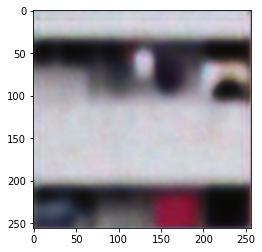

loss : 0.09160138666629791        mean loss : 0.08732530131787802
model saved.

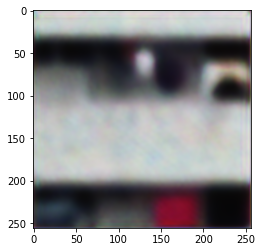

loss : 0.09355447441339493        mean loss : 0.08779509047485665
model saved.

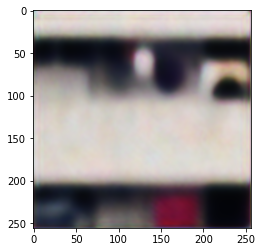

loss : 0.08987543731927872        mean loss : 0.0863260443686993
model saved.

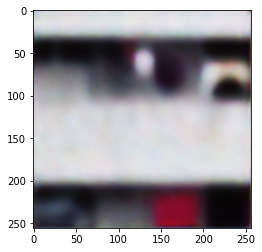

loss : 0.08058201521635056        mean loss : 0.08540137321827654
model saved.

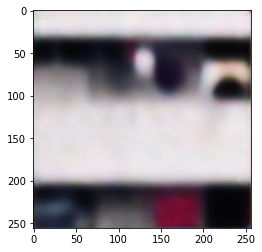

loss : 0.07462941855192184        mean loss : 0.08422650601373932
model saved.

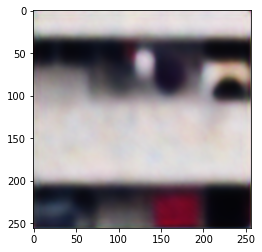

loss : 0.09296464174985886        mean loss : 0.08398217807780319
model saved.

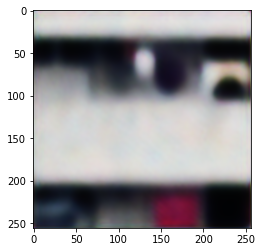

loss : 0.06487499922513962        mean loss : 0.08370502869809016
model saved.

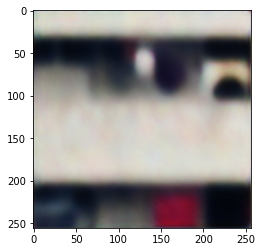

loss : 0.06674931198358536        mean loss : 0.08369915201416556
model saved.

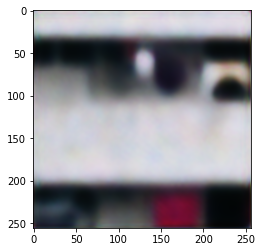

loss : 0.0661287009716034        mean loss : 0.08333756478427054
model saved.

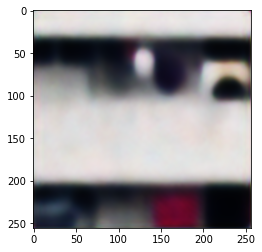

loss : 0.08678915351629257        mean loss : 0.08305724332283347
model saved.

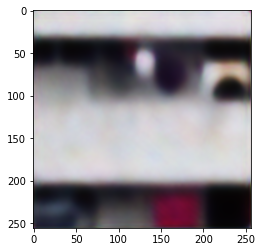

loss : 0.07466171681880951        mean loss : 0.08265489204278795
model saved.

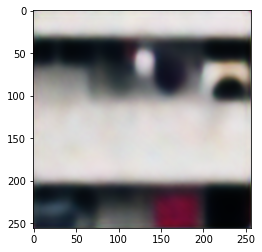

loss : 0.09364791959524155        mean loss : 0.0824737199492678
model saved.

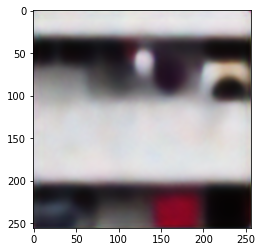

loss : 0.08872294425964355        mean loss : 0.08231658242818375
model saved.

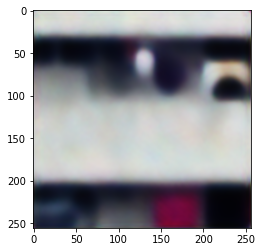

loss : 0.07177066802978516        mean loss : 0.08236281925675275

In [ ]:
for epoch  in range(2):
  losses = []
  for batch in tqdm(range(len(hr_iter))):
    lr_batch = next(lr_iter)
    hr_batch = next(hr_iter)

    out = PSNR_model.train_on_batch(lr_batch, hr_batch,return_dict=True)
    losses.append(out['loss'])
    print('\rloss :',out['loss'],
          '       mean loss :',sum(losses)/len(losses),end='')

    # save model after each 200 batch
    if batch % 100 == 0 and batch != 0:
      PSNR_model.save('saved_psnr/batch%d(sigmid).h5'%batch)
      print('\nmodel saved.',end='')
      pred = PSNR_model.predict(LRtest_sample)
      #pred = pred.astype(np.uint8)
      plt.imshow(pred[0])
      plt.savefig('%d(sigmoid).png'%batch)
      plt.show()


# train ESRGAN

In [ ]:
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

def lr_decay(initial_lr):
  bound = list(range(200000,1000001,200000))
  lr_values = [initial_lr]
  for _ in bound:
    lr_values.append(lr_values[-1]/2.)
  
  return PiecewiseConstantDecay(boundaries=bound, values=lr_values)

In [ ]:
%cd ESRGAN-Datasets

/content/ESRGAN-Datasets


In [ ]:
seed = 10
size = 256
lrGen = ImageDataGenerator(rescale=1/255.)
hrGen = ImageDataGenerator(rescale=1/255.)

lr_gen = lrGen.flow_from_directory('LR',target_size=(size//4,size//4),class_mode=None,batch_size=4,seed=seed)
hr_gen = hrGen.flow_from_directory('HR',target_size=(size,size),class_mode=None,batch_size=4,seed=seed)

lr_iter = iter(lr_gen)
hr_iter = iter(hr_gen)

Found 32312 images belonging to 10 classes.
Found 32312 images belonging to 10 classes.


In [ ]:
#-----define Discriminator model-----------
#discriminator = Discriminator_Model(256)
discriminator = load_model('../drive/MyDrive/ESRGAN_out/discriminator23000.h5')

lr_D = lr_decay(initial_lr=1e-4)
optimizer_D = Adam(learning_rate=lr_D)

#-----define the model that trains generator-------
#generator = Generator_model(size=256//4)
generator = load_model('../drive/MyDrive/ESRGAN_out/generator23000.h5')

#---define loss
L1_loss = MeanAbsoluteError()
percep_loss = percepLoss()
#---define optimizer

lr_G = lr_decay(initial_lr=1e-4)
optimizer_G = Adam(learning_rate=lr_G)

80150528/80134624 [==============================] - 3s 0us/step


In [ ]:
baboon = cv2.imread('../drive/MyDrive/ESRGAN_out/baboon.png')
baboon = cv2.cvtColor(baboon, cv2.COLOR_BGR2RGB)/255.
baboon = np.expand_dims(baboon, axis=0)

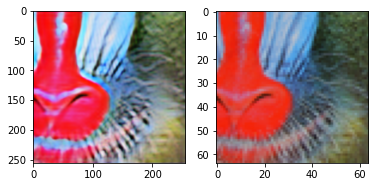

In [ ]:
sr = generator(baboon)
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(sr[0])

fig.add_subplot(1,2,2)
plt.imshow(baboon[0])
plt.show()

In [ ]:
for epoch in range(1):
  for batch in tqdm(range(len(hr_iter))):

    #-----train Discriminator----
    #--discriminator inputs
    hr_batch = next(hr_iter)
    lr_batch = next(lr_iter)
    sr_batch = generator.predict(lr_batch)
    
    #--discriminator labels
    hr_label = np.ones((hr_batch.shape[0]))
    sr_label = np.zeros((sr_batch.shape[0]))

    #--train discriminator
    with tf.GradientTape() as tape:
      sr_pred = discriminator(sr_batch, training=True)
      hr_pred = discriminator(hr_batch, training=True)
      loss_D = RaD_loss(hr_pred, sr_pred)
    
    grads = tape.gradient(loss_D, discriminator.trainable_weights)
    optimizer_D.apply_gradients(zip(grads, discriminator.trainable_weights))


    #------train generator------
    #--generator inputs & labels
    hr_batch = next(hr_iter)
    lr_batch = next(lr_iter)

    #--train generator
    with tf.GradientTape() as tape:
      sr_batch = generator(lr_batch, training=True)

      discriminator.trainable = False
      srDisc_out = discriminator(sr_batch)
      hrDisc_out = discriminator(hr_batch)

      L1 = L1_loss(hr_batch, sr_batch)
      percep = percep_loss(hr_batch, sr_batch)
      RaG = RaG_loss(hrDisc_out, srDisc_out)
      loss_G = percep + 5e-3*RaG + 0.01*L1
    
    grads = tape.gradient(loss_G, generator.trainable_weights)
    optimizer_G.apply_gradients(zip(grads, generator.trainable_weights))

    print('\rDiscriminator loss :',loss_D,
          '      Generator loss :',loss_G, end='')
    if batch%500 == 0 and batch != 0:
      test_out = generator(baboon)
      img = np.uint8(test_out[0]*255)
      img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
      
      cv2.imwrite('../drive/MyDrive/ESRGAN_out/%d.png'%(batch+23500),img)

      generator.save('../drive/MyDrive/ESRGAN_out/generator%d.h5'%(batch+23500))
      discriminator.save('../drive/MyDrive/ESRGAN_out/discriminator%d.h5'%(batch+23500))



  0%|          | 0/8078 [00:00<?, ?it/s]

Discriminator loss : tf.Tensor(0.69056886, shape=(), dtype=float32)       Generator loss : tf.Tensor(5.894875, shape=(), dtype=float32)WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Discriminator loss : tf.Tensor(0.691309, shape=(), dtype=float32)       Generator loss : tf.Tensor(3.9153132, shape=(), dtype=float32)WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Discriminator loss : tf.Tensor(0.6910671, shape=(), dtype=float32)       Generator loss : tf.Tensor(1.672993, shape=(), dtype=float32)WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Discriminator loss : tf.Tensor(0.6916527, shape=(), dtype=float32)       Generator loss